In [39]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

#system lib
import os

# 3rd party lib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

# astro lib
from astropy.io import fits
import sep

# my lib
import ImageTools as it

In [14]:
def make_nonnegative(img):
    epsilon = 0 if len(img[img<0])==0 else img[img>0].min()
    return img + abs(img.min()) + epsilon

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
    
    if num==-1:
        num = len(spheroids)
    
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)

    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img.copy(), segmap.copy(), img_id))
        del img 
        del segmap
    
    return sources

# Petrosian Helpers ----------------------------------------------------------
def one_over_eta(rs, fs, R):
    return ((np.pi*R**2) / (np.sum(fs[rs<=R]))) * fs[rs==R]

def petrosian_radius(rs, fs):
    r_candidates = np.array([one_over_eta(rs, fs, R) for R in rs])
    return rs[np.square(r_candidates-0.2).argmin()]

def petrosian_flux(rs, fs, R_p):
    return np.sum(fs[rs<=2*R_p])

def R_x(rs, fs, x):
    x /= 100
    sum_ratio = np.cumsum(fs)/np.sum(fs)
    return rs[np.square(sum_ratio-x).argmin()]

def petrosian_Re(R_50, R_90):
    P_3 = 8e-6
    P_4 = 8.47
    return R_50 / (1 - P_3*(R_90/R_50)**P_4)

def get_rs_and_fs(img, src_map):
    cx, cy = it.img_center(img, src_map)
    xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
    rs = np.sqrt(np.square(xs-cx)+np.square(ys-cy))
    
    rs = rs.flatten()
    fs = img.flatten()
    sorted_rs = np.argsort(rs)
    
    rs = rs[sorted_rs]
    fs = fs[sorted_rs]
    
    return rs, fs

def get_re(img, src_map):
    rs, fs = get_rs_and_fs(img, src_map)
    
    R_p = petrosian_radius(rs, fs)
    F_p = petrosian_flux(rs, fs, R_p)
    p_mask = rs <= 2*R_p
    
    rs = rs[p_mask]
    fs = fs[p_mask]

    R_50 = R_x(rs, fs, 50)
    R_90 = R_x(rs, fs, 90)

    re = petrosian_Re(R_50, R_90)
    re_idx = np.square(rs-re).argmin()
    
    return rs[re_idx]
# Petrosian Helpers ----------------------------------------------------------

In [52]:
re_exceeded = []
spheroids = get_random_spheroids(num=-1)

res = []
normed_rs = []
normed_fs = []
for img, segmap, img_id in spheroids:
    #background subtract images
    src_map = segmap==img_id
    array_sep_likes = img.byteswap().newbyteorder()
    bkg = sep.Background(array_sep_likes, mask=src_map, bw=10, bh=10)
    img = make_nonnegative(img-bkg)
    
    # measure petrosian re 
    re = get_re(img, src_map)
    res.append(re)    
    
    # measure out to 5re and integrate
    rs, fs = get_rs_and_fs(img, src_map)
    
    re_idx = np.where(rs==re)[0][0] 
    ie = fs[re_idx-3:re_idx+3].mean()
    
    # check that 5re is a valid number
    if (5*re > rs.max()):
        re_ratio = re/rs.max()
        re_exceeded.append(re_ratio)
        
        rs = rs/re
        fs = fs/ie

        normed_rs.append((rs,re_ratio))
        normed_fs.append(fs)
        
    else:
        r_mask = rs <= 5*re
        rs = rs[r_mask]/re
        fs = fs[r_mask]/ie

        normed_rs.append((rs,0))
        normed_fs.append(fs)

/home/ryanhausen/anaconda3/envs/sep/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: Mean of empty slice.
/home/ryanhausen/anaconda3/envs/sep/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


366
500


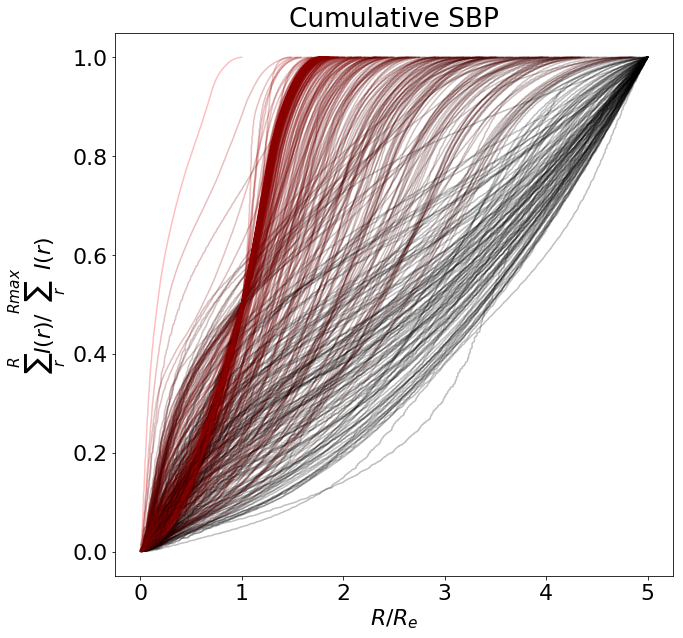

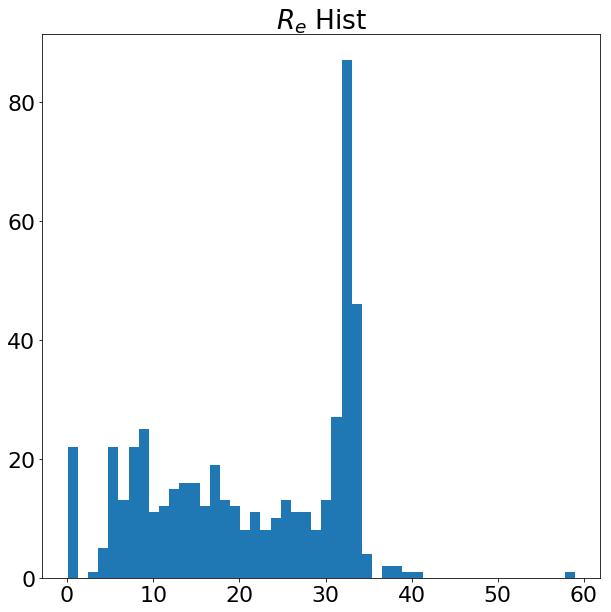

In [53]:
print(len(re_exceeded))
print(len(spheroids))
f_size = (10,10)

plt.figure(figsize=f_size)
plt.title('Cumulative SBP')
plt.ylabel('$\sum_r^R I(r) / \sum_r^{Rmax} I(r)$')
plt.xlabel('$R/R_e$')
for (r,e), y in zip(normed_rs, normed_fs):
    color = (e, 0, 0)
    plt.plot(r, np.cumsum(y)/y.sum(), color=color, alpha=0.25)

plt.figure(figsize=f_size)
plt.title('$R_e$ Hist')
plt.hist(res, bins=50)


plt.show()